Importing library

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', None)
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

data and test data(read)

In [4]:
data = pd.read_csv('/content/kaggle_train_data_public.csv')
test_data = pd.read_csv('/content/kaggle_test_features_public.csv')

feature of data

In [5]:
def getDataframeOverview(df, message):
    print(message)
    print('Number of rows: ', df.shape[0])
    print('Number of features:', df.shape[1])
    print('Data Features:')
    print(df.columns.tolist())
    print('Missing values:', df.isnull().sum().values.sum())
    print('Unique values:')
    print(df.nunique())

getDataframeOverview(data, 'Overview of the train dataset')
print('-'*100)
getDataframeOverview(test_data, 'Overview of the test dataset')

Overview of the train dataset
Number of rows:  3944
Number of features: 31
Data Features:
['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Churn Score', 'Churn Value', 'CLTV', 'Churn Reason']
Missing values: 2899
Unique values:
CustomerID           3944
Count                   1
Country                 1
State                   1
City                 1102
Zip Code             1611
Lat Long             1611
Latitude             1611
Longitude            1610
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3

data.columns

remove columns

In [6]:
data.drop(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Score', 'CLTV', 'Churn Reason'],axis=1,inplace = True)
test_data.drop(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude'],axis=1,inplace = True)

In [7]:
data['Total Charges'] = data['Tenure Months'] + data['Monthly Charges']
test_data['Total Charges'] = test_data['Tenure Months'] + test_data['Monthly Charges']

In [8]:
data['Sub Charges'] =data['Monthly Charges'] - data['Tenure Months']
test_data['Sub Charges'] =test_data['Monthly Charges'] - test_data['Tenure Months']

change boolen to 0 and 1

In [9]:
binary_list = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']

def binary_map(feature):
    return feature.map({'Yes':1, 'No':0})

data['Gender'] = data['Gender'].map({'Male':1, 'Female':0})
test_data['Gender'] = test_data['Gender'].map({'Male':1, 'Female':0})

data[binary_list] = data[binary_list].apply(binary_map)
test_data[binary_list] = test_data[binary_list].apply(binary_map)

data = pd.get_dummies(data, drop_first=True)
test_data = pd.get_dummies(test_data, drop_first=True)

minmax scaler(between 0 and 1)

In [10]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization

data['Tenure Months'] = mms.fit_transform(data[['Tenure Months']])
data['Monthly Charges'] = mms.fit_transform(data[['Monthly Charges']])
data['Total Charges'] = mms.fit_transform(data[['Total Charges']])
data['Sub Charges'] = mms.fit_transform(data[['Sub Charges']])

test_data['Tenure Months'] = mms.fit_transform(test_data[['Tenure Months']])
test_data['Monthly Charges'] = mms.fit_transform(test_data[['Monthly Charges']])
test_data['Total Charges'] = mms.fit_transform(test_data[['Total Charges']])
test_data['Sub Charges'] = mms.fit_transform(test_data[['Sub Charges']])

In [11]:
churnValue = data['Churn Value']
data.drop(['Churn Value'], axis = 1, inplace = True)
data['Churn Value'] = churnValue

In [12]:
data.shape

(3944, 32)

imbalance

In [13]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy='auto')

x = data.iloc[:,:31].values
y = data.iloc[:,31].values

x, y = over.fit_resample(x, y)
Counter(y)

Counter({0: 2899, 1: 2899})

In [14]:
print(data.shape)
print(test_data.shape)

(3944, 32)
(986, 31)


In [15]:
# Import Machine learning algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
#Neural Networks(din't do)
from keras.models import Sequential
from keras.layers import Dense

# Import metric for performance evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

# Model selection
from sklearn.model_selection import RepeatedStratifiedKFold

In [16]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.001, random_state=42)

In [17]:
def model(classifier,x_train,y_train,x_test,y_test):
  mod = classifier.fit(x_train,y_train)
  prediction = classifier.predict(x_test)
  cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
  print("Accuracy: {:.2%}".format(accuracy_score(y_test, prediction)))
  RocCurveDisplay.from_estimator(classifier, x_test,y_test)
  return mod

Accuracy: 50.00%


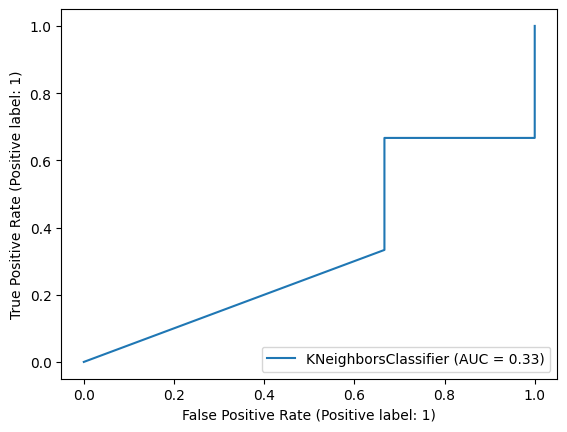

In [18]:
#kNN
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_model = model(knn_classifier,X_train,y_train,X_test,y_test)

Accuracy: 83.33%


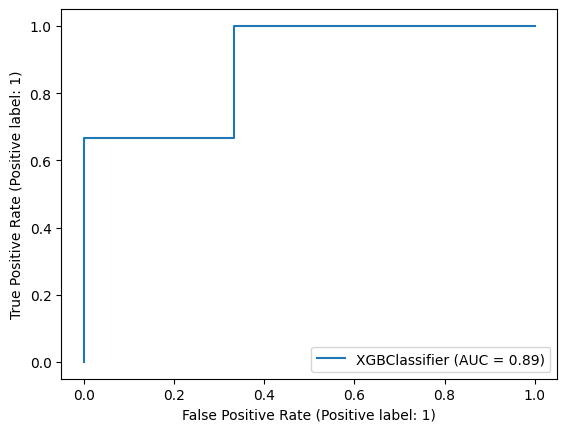

In [19]:
# XGBClassifier
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 5,n_estimators = 10000,booster='gbtree',objective='binary:logistic', random_state=82)
xgb_model = model(classifier_xgb,X_train,y_train,X_test,y_test)


Accuracy: 66.67%


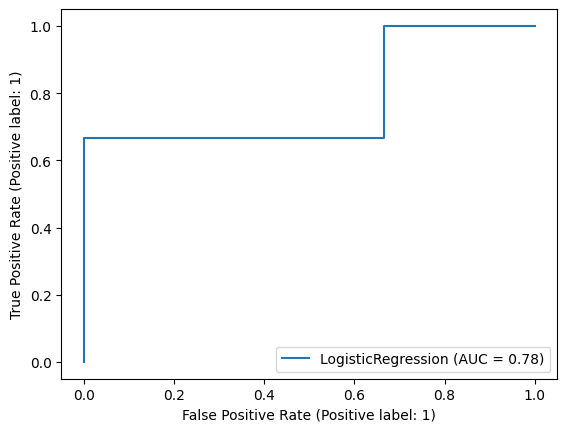

In [20]:
#Logistic Regression
classifier_lg = LogisticRegression(tol=0.0034, C=2.1, intercept_scaling=10)
lg_model = model(classifier_lg,X_train,y_train,X_test,y_test)

Accuracy: 66.67%


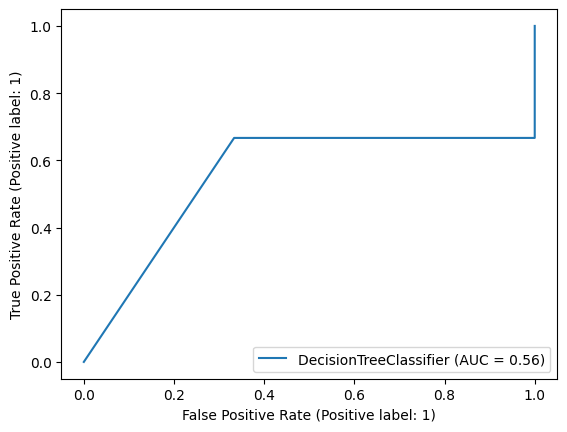

In [21]:
# DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(random_state = 100,max_depth = 4,min_samples_leaf = 1)
dt_model = model(classifier_dt,X_train,y_train,X_test,y_test)

Accuracy: 66.67%


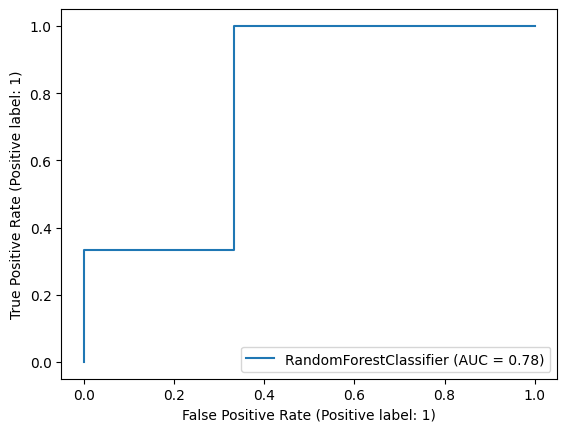

In [22]:
# RandomForestClassifier

classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 42)
rf_model = model(classifier_rf,X_train,y_train,X_test,y_test)

Accuracy: 66.67%


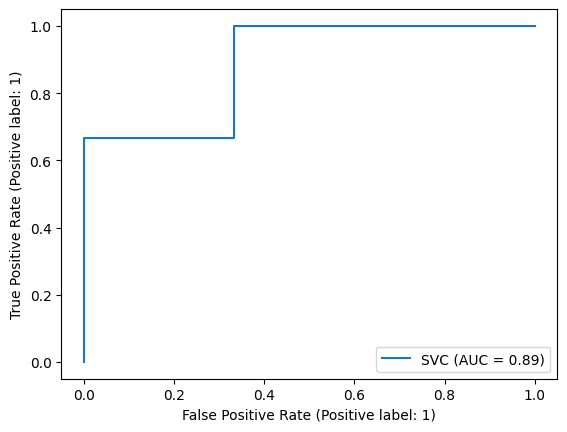

In [23]:
# SVC

classifier_svc = SVC(probability=True)
svc_model = model(classifier_svc,X_train,y_train,X_test,y_test)

Accuracy: 50.00%


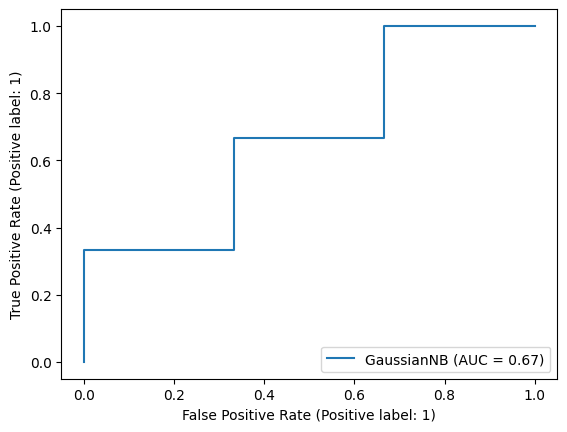

In [24]:
# Naive bayes

classifier_gnb = GaussianNB()
gnb_model = model(classifier_gnb,X_train,y_train,X_test,y_test)

In [25]:
predictions_proba = lg_model.predict_proba(test_data)[:, 1]
submission_df = pd.DataFrame({'ID': range(len(test_data)), 'Churn Value': predictions_proba})
submission_df.to_csv("submission_file_name.csv", index=False)